# 비화재보 분류 


---
## 1. 데이터 전처리     
---

### 각 년도별 데이터 결합 

In [2]:
import pandas as pd
import numpy as np 
import re
import pickle
import xlrd
import  matplotlib.pyplot as plt
from konlpy.tag import Okt 
okt = Okt()

start_year= 2016
end_year =2021

In [ ]:
df_all =pd.DataFrame()
#년도합치기
for year in range(start_year,end_year+1):
#시트 이름 가져오기    
    wb = xlrd.open_workbook(f"{year}년 전체 신고건수_관할 및 재난주소 추가.xls")
    globals()[f'df_{year}']=pd.DataFrame()
#Sheet 합치기
    for  i in range(len(wb.sheets())):
        tmp = pd.read_excel(f"{year}년 전체 신고건수_관할 및 재난주소 추가.xls",sheet_name = wb.sheet_names()[i])['신고내용'].dropna(axis=0).T
        globals()[f'df_{year}']= pd.concat([globals()[f'df_{year}'],tmp], axis = 0)
    df_all= pd.concat([df_all,globals()[f'df_{year}']], axis = 0)

##### 임시저장

In [2]:
# with open(f"119_신고내용_{start_year} - {end_year}.pickle","wb") as fw:
#     pickle.dump(df_all, fw)   
with open(f"119_신고내용_{start_year} - {end_year}.pickle",'rb') as fr:
    df_all = pickle.load(fr)

### 중복 문자열 제거

In [3]:
print(len(df_all))
df_all= pd.DataFrame(set(df_all[0]))
print(len(df_all))
print(df_all.head(3))

1711724
1368100
                                  0
0  [의식 있음] 내당홈플러스 3층 꽃집 앞 / 여성 쓰러짐 
1        동구시장 풀과 나무 한의원//호흡곤란 사지 마비
2                ★★주간 기동순찰 및 훈련출동★★


###  신고내용 전처리 

In [84]:
from konlpy.tag import Okt 
okt = Okt()
print(okt.pos('속보기'))  #속보기 한 단어로 인식 X   -> AAA로 임시 치환
print(okt.pos('오작동')) # 오+작동으로 분리된 후 오가 제거되어 의미가 왜곡 -> BBB로 임시 치환
# 문제X
print(okt.pos('경보기'),okt.pos('경보'),okt.pos('속보')) 

[('속', 'Modifier'), ('보기', 'Noun')]
[('오', 'Modifier'), ('작동', 'Noun')]
[('있다', 'Adjective')]
[('경보기', 'Noun')] [('경보', 'Noun')] [('속보', 'Noun')]


In [6]:
df_all2 = df_all.copy()
for i in range(len(df_all2)):
    tmp = re.sub(r'[^가-힣+ ]',' ',df_all2.iloc[i,0]) # 한글말고 제거
    tmp = re.sub('속보기','AAA',tmp) # 속보기 ->A로 단어 치환    
    tmp = re.sub('오작동','BBB',tmp) # 오작동 ->B로 단어 치환    
    df_all2.iloc[i,0] = tmp
df_all2.iloc[702307 ,0]=re.sub('속보기','속보', df_all2.iloc[702307 ,0]) # 알수없는 이유로 치환이 안됨
print(df_all2.head(3))
print(len(df_all2))

                                            0
1                       문의 아이 아픔 아침 내원 가능 병원 
2   추가 라일락 아파트        호    갑자기 쓰러진후 몸을 떨고 있다 
3                       문의 아이 아픔 아침 내원 가능 병원 
1711724


In [31]:
#속보기 단어 제거 확인
print(f'속보기 단어 변경 전   : {df_all[0].apply(lambda x: re.search("속보기", x)is not None).sum()}')
print(f'속보기 단어 변경 후 :{df_all2[0].apply(lambda x: re.search("속보기", x)is not None).sum()}')
print(f'AAA 단어 변경 후 :{df_all2[0].apply(lambda x: re.search("AAA", x)is not None).sum()}')
print(f'속보기 단어 변경 전   : {df_all[0].apply(lambda x: re.search("오작동", x)is not None).sum()}')
print(f'오작동 단어 변경 후 :{df_all2[0].apply(lambda x: re.search("오작동", x)is not None).sum()}')
print(f'BBB 단어 변경 후 :{df_all2[0].apply(lambda x: re.search("BBB", x)is not None).sum()}')
# print(f'제거 안된 문장 :{df_all2[0][df_all2[0].apply(lambda x: re.search("속보기", x)is not None)]}')

속보기 단어 변경 전   : 8995
속보기 단어 변경 후 :0
속보기 단어 변경 전   : 11051
오작동 단어 변경 후 :0
AAA 단어 변경 후 :4
BBB 단어 변경 후 :6
AAA 단어 변경 후 :8995
BBB 단어 변경 후 :11051


###  문장 -> 형태소 형태로 변환
형태소 분석(Noun, Adjective) -명사와 형용사만  
1 글자를 배제  -의미가 거의X  
불용어 제외  

In [100]:

sents = []
for i in range(len(df_all2[0])):
    print("\r[tokenizing]  {}  /  {}   {}  %".format(i+1, len(df_all2[0]), round( (i / len(df_all2[0])) * 100 , 1 ) ), end = '    ', flush = False)
    pos_res = okt.pos(df_all2[0].iloc[i])
    
    STOP_WORDS = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
    keywords = []
    for word, pos in pos_res:
        if ((pos == "Noun")|(pos == "Adjective")| (pos =='Alpha'))&(len(word) >= 2)&(word not in STOP_WORDS):
            word = word.replace('AAA', '속보기')
            word = word.replace('BBB','오작동') # 원래 단어로 되돌리기
            keywords.append(word)
    sents.append(' '.join(keywords))
# print(sents[0:5])

[tokenizing]  1711724  /  1711724   100.0  %                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [4]:
# with open(f"119전처리_{start_year}-{end_year}.pickle","wb") as fw:
#     pickle.dump(sents, fw)   
with open(f"119전처리_{start_year}-{end_year}.pickle",'rb') as fr:
    sents = pickle.load(fr)

###  전처리 전후 키워드 갯수 확인
비화재보 주요 키워드 : 경보, 속보  
비화재보 제외 키워드 : 테스트, 오인주의, 훈련, 점검   

#### 경보, 속보  

In [101]:
check = []
for i in range(len(sents)) :
    if '속보' in sents[i]:
            check.append(sents[i])
print(f'기존 [속보] 단어 수: {df_all2[0].apply(lambda x: re.search("속보", x)is not None).sum()}')
print(f'전처리 후 [속보] 단어 수: {len(check)}\n')  
check = []
for i in range(len(sents)) :
    if '경보' in sents[i]:
            check.append(sents[i])
print(f'기존 [경보] 단어 수: {df_all2[0].apply(lambda x: re.search("경보", x)is not None).sum()}')
print(f'전처리 후 [경보] 단어 수: {len(check)}\n')  

기존 [속보] 단어 수: 9217
전처리 후 [속보] 단어 수: 18038

기존 [경보] 단어 수: 16910
전처리 후 [경보] 단어 수: 16792



#### 테스트, 오인주의, 훈련, 점검   

In [102]:
check = []
for i in range(len(sents)) :
    if '점검' in sents[i]:
            check.append(sents[i])
print(f'기존 [점검] 단어 수: {df_all2[0].apply(lambda x: re.search("점검", x)is not None).sum()}')
print(f'전처리 후 [점검] 단어 수: {len(check)}\n')  
# df_all2[df_all2[0].apply(lambda x: re.search("점검", x)is not None)]
check = []
for i in range(len(sents)) :
    if '훈련' in sents[i]:
            check.append(sents[i])
print(f'기존 [훈련] 단어 수: {df_all2[0].apply(lambda x: re.search("훈련", x)is not None).sum()}')
print(f'전처리 후 [훈련] 단어 수: {len(check)}\n')  
# df_all2[df_all2[0].apply(lambda x: re.search("훈련", x)is not None)]
check = []
for i in range(len(sents)) :
    if '오인' in sents[i]:
            check.append(sents[i])
print(f'기존 [오인] 단어 수: {df_all2[0].apply(lambda x: re.search("오인", x)is not None).sum()}')
print(f'전처리 후 [오인] 단어 수: {len(check)}\n')  
# df_all2[df_all2[0].apply(lambda x: re.search("오인", x)is not None)]
check = []
for i in range(len(sents)) :
    if '테스트' in sents[i]:
            check.append(sents[i])
print(f'기존 [테스트] 단어 수: {df_all2[0].apply(lambda x: re.search("테스트", x)is not None).sum()}')
print(f'전처리 후 [테스트] 단어 수: {len(check)}\n')  
# df_all2[df_all2[0].apply(lambda x: re.search("테스트", x)is not None)]


기존 [점검] 단어 수: 2433
전처리 후 [점검] 단어 수: 2431

기존 [훈련] 단어 수: 4373
전처리 후 [훈련] 단어 수: 4373

기존 [오인] 단어 수: 13180
전처리 후 [오인] 단어 수: 12967

기존 [테스트] 단어 수: 22230
전처리 후 [테스트] 단어 수: 22230



In [103]:
check = []
for i in range(len(sents)) :
    if 'AAA' in sents[i]:
            check.append(sents[i])
print(f'기존 [AAA] 단어 수: {df_all2[0].apply(lambda x: re.search("AAA", x)is not None).sum()}')
print(f'전처리 후 [AAA] 단어 수: {len(check)}\n')  
check = []
for i in range(len(sents)) :
    if 'BBB' in sents[i]:
            check.append(sents[i])
print(f'기존 [BBB] 단어 수: {df_all2[0].apply(lambda x: re.search("BBB", x)is not None).sum()}')
print(f'전처리 후 [BBB] 단어 수: {len(check)}\n')  
check = []
for i in range(len(sents)) :
    if '속보기' in sents[i]:
            check.append(sents[i])
print(f'기존 [속보기] 단어 수: {df_all2[0].apply(lambda x: re.search("속보기", x)is not None).sum()}')
print(f'전처리 후 [속보기] 단어 수: {len(check)}\n')  
check = []
for i in range(len(sents)) :
    if '오작동' in sents[i]:
            check.append(sents[i])
print(f'기존 [오작동] 단어 수: {df_all2[0].apply(lambda x: re.search("오작동", x)is not None).sum()}')
print(f'전처리 후 [오작동] 단어 수: {len(check)}\n')  

기존 [AAA] 단어 수: 8995
전처리 후 [AAA] 단어 수: 0

기존 [BBB] 단어 수: 11051
전처리 후 [BBB] 단어 수: 0

기존 [속보기] 단어 수: 0
전처리 후 [속보기] 단어 수: 8995

기존 [오작동] 단어 수: 0
전처리 후 [오작동] 단어 수: 11051



#### 비화재보 /화재 데이터 분리

In [5]:
#화재보
df_sents = pd.DataFrame(sents)
non_fire=[]
fire=[]
for i in range(len(sents)):
    print("\r[비화재보 분류]  {}  /  {}   {}  %".format(i+1, len(sents), round( (i / len(sents)) * 100 , 1 ) ), end = '    ', flush = False)
    if (('경보' in df_sents.iloc[i,0])|('속보' in df_sents.iloc[i,0])) and (('점검' not in df_sents.iloc[i,0])&('훈련' not in df_sents.iloc[i,0])&('오인' not in df_sents.iloc[i,0])&('테스트' not in df_sents.iloc[i,0])):
        non_fire.append(df_sents.iloc[i,0])
    else :
        fire.append(df_sents.iloc[i,0]) 
print( f'\n비화재보 / 전체 데이터 : {len(non_fire)} / {len(sents)} \n비화재보 비율 : {round((len(non_fire)/ len(sents))*100,2)}%')        

[비화재보 분류]  1711724  /  1711724   100.0  %                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [10]:
df_non_fire=pd.DataFrame(non_fire)
print("비화재보 데이터 ")
print(f'[경보] 단어 수: {df_non_fire[0].apply(lambda x: re.search("경보", x)is not None).sum()}')
print(f'[속보] 단어 수: {df_non_fire[0].apply(lambda x: re.search("속보", x)is not None).sum()}')
print(f'[테스트] 단어 수: {df_non_fire[0].apply(lambda x: re.search("테스트", x)is not None).sum()}')
print(f'[훈련] 단어 수: {df_non_fire[0].apply(lambda x: re.search("훈련", x)is not None).sum()}')
print(f'[오인] 단어 수: {df_non_fire[0].apply(lambda x: re.search("오인", x)is not None).sum()}')
print(f'[점검] 단어 수: {df_non_fire[0].apply(lambda x: re.search("점검", x)is not None).sum()}')
# df_non_fire[df_non_fire[0].apply(lambda x: re.search("테스트", x)is not None)]

비화재보 데이터 
[경보] 단어 수: 16397
[속보] 단어 수: 10725
[테스트] 단어 수: 0
[훈련] 단어 수: 0
[오인] 단어 수: 0
[점검] 단어 수: 0


##### 임시저장

In [10]:
# with open(f"비화재보_{start_year}-{end_year}.pickle","wb") as fw:
#     pickle.dump(non_fire, fw)   
# with open(f"화재_{start_year}-{end_year}.pickle","wb") as fw:
#     pickle.dump(fire, fw)   
with open(f"비화재보_{start_year}-{end_year}.pickle",'rb') as fr:
    non_fire = pickle.load(fr)
        
with open(f"화재_{start_year}-{end_year}.pickle",'rb') as fr:
    fire = pickle.load(fr)    

In [ ]:
##함수만들어서 다음에 쓰기

# STOP_WORDS = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
# def make_tonken(df,STOP_WORDS):

#     for i in range(len(df)):
#         print("\r[tokenizing]  {}  /  {}   {}  %".format(i+1, len(df), round( (i / len(df)) * 100 , 1 ) ), end = '    ', flush = False)
#         text = re.sub(r'[^0-9a-zA-Zㄱ-ㅎ가-힣]',' ',df.iloc[i,0]) # 한글/숫자/영어
#         pos_res = okt.pos(text)
#         keywords = []
#         for word, pos in pos_res:
#             if ((pos == "Noun")|(pos == "Adjective")|(pos =='Alpha'))&(len(word) >= 2)&(word not in STOP_WORDS): # 단어형식제한 / 길이제한/ 불용어제한
#                 keywords.append(word)
#         sents.append(' '.join(keywords))    

---
## 2. 분석
---

In [21]:

import gensim
import pandas as pd
import os
import pickle
import re
#import pyLDAvis.gensim
from gensim import corpora
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
from wordcloud import WordCloud
import  matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
#from iteration_utilities import deepflatten  ## list flatten 
import random
from collections import Counter
import time
from datetime import datetime 
import matplotlib.font_manager
import networkx as nx
import matplotlib.font_manager as fm
import math
from sklearn.manifold import TSNE
from gensim.models import CoherenceModel
# from soynlp.tokenizer import LTokenizer
# from soynlp.noun import LRNounExtractor_v2

matplotlib.font_manager.findSystemFonts(fontpaths  = None , fontext = 'ttf') # 활용가능한 폰트 찾기 

def make_dtm(text, max_features = 1000000, min_df = 1, stopwords = None):
    while True:
        cv =  CountVectorizer(max_features= max_features, 
                              min_df = min_df, 
                              stop_words = stopwords,
                              tokenizer = lambda x: x.split(' '))
        tdm = cv.fit_transform(text)
        words = cv.get_feature_names()
                
        try:
            tdm_mat = tdm.toarray()
        except MemoryError:
            min_df += 1000
            print("\rmin_freq:{}".format(min_df), end = " ")
        else:
            break

    tdm_df = pd.DataFrame(tdm_mat)
    tdm_df.columns= np.array(words)
    return tdm_df

def make_wordcloud(dtm_mat, width=1000, height=500, max_words = 500):
    dtm_mat_sum = dtm_mat.sum(axis = 0)
    wc_dic = {}
    for i in range(len(dtm_mat_sum)):
        wc_dic[dtm_mat_sum.index[i]] = int(dtm_mat_sum.iloc[i])
    wordcloud = WordCloud(font_path=r"C:\Windows\Fonts\malgun.ttf",
                          width = width, height = height,
                          background_color = "white",
                          max_words=max_words).generate_from_frequencies(wc_dic)    
    return wordcloud

def analy_asso(dtm_mat, support, confidence):
    asso_data = dtm_mat.apply(lambda x: np.where(x ==0, False, True), axis = 0)        
    while True:
        try:
            asso_gen = apriori(asso_data, min_support=support, use_colnames=True,
                                   max_len = 2, low_memory = True)
        except MemoryError:    
            support += 0.0001
            print("\rsupport:",support, end = " ")
        else:
            break
            
    asso_cut_confidence = association_rules(asso_gen, metric="confidence", min_threshold= confidence )
    return(asso_cut_confidence)

def make_network(asso_rules, font_size = 10, eps = .1, figure = True):
    sample_g = nx.Graph()
    for i in range(len(asso_rules)):
        sample_g.add_edge(" ".join(list(asso_rules["antecedents"][i])),
                              " ".join(list(asso_rules["consequents"][i])),
                              weight = asso_rules["support"].iloc[i])
            
    pgr_cen = nx.pagerank(sample_g) ## 페이지링크 알고리즘을 해당노드의 연결성(엣지 웨이트)
    sorted_pgr = sorted(pgr_cen.items(), key = (lambda x:x[1]), reverse = True)
        
    graphic_g = nx.Graph()

    for i in range(len(sorted_pgr)):
        graphic_g.add_node(sorted_pgr[i][0])
                            
    for j in range(len(asso_rules)):
        graphic_g.add_weighted_edges_from(
                    [ (" ".join(list(asso_rules["antecedents"][j])),
                       " ".join(list(asso_rules["consequents"][j])),
                       asso_rules["support"].iloc[j] * 100 )])
        
    weight_list = ["떡볶이"]
    node_weight = []
    for key, values in pgr_cen.items():
        if key in weight_list:
                node_weight.append(math.log(values * 50000 * 10000)* 500)
        else:
            node_weight.append(math.log(values * 50000)* 500)
    
    if figure:
        nx.draw(graphic_g, 
                node_color = 'white',
                nodelist = pgr_cen.keys(),
                node_size = node_weight,
                edge_color= "#2090e6", 
                pos = nx.spring_layout(graphic_g,k = eps), 
                font_size = font_size,
                font_family = 'NanumGothic',
                with_labels = True,
                font_weight = 'bold',
                alpha = 1,
                font_color = "black",
                edgecolors = "#2090e6",
                linewidths = 2)
    
    else:
        return sorted_pgr


### topic modeling -> LDA 

def compute_coherence_values(text, limit, start=2, step=3):
    
    text = [words.split(" ") for words in text]  
    dictionary = corpora.Dictionary(text)
    corpus = [dictionary.doc2bow(text) for text in text]
    coherence_values = []
    model_list = []
    perplexity_values = []
    for num_topics in range(start, limit, step):
        print("Topics: {}".format(num_topics))
        model = gensim.models.ldamodel.LdaModel(corpus, 
                                               id2word=dictionary, 
                                               num_topics = num_topics, 
                                               update_every = 1,
                                               #chunksize = round(len(corpus)/20),
                                               passes=10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=text, dictionary=dictionary, coherence='c_v')        
        perplexitymodel = model.log_perplexity(corpus)
        
        coherence_values.append(coherencemodel.get_coherence())
        perplexity_values.append(perplexitymodel)
        
    return model_list, coherence_values, perplexity_values

def run_lda(text, num_topics):
    """
    text: 문장
    num_topics: 도출할 토픽의 수
    num_words: 토픽당 출력할 단어의 수(시각화용)
    """
    text = [words.split(" ") for words in text]  
    dictionary = corpora.Dictionary(text)
    corpus = [dictionary.doc2bow(text) for text in text]

    ldamodel = gensim.models.ldamodel.LdaModel(corpus, 
                                               id2word=dictionary, 
                                               num_topics = num_topics, 
                                               update_every = 1,
                                               #chunksize = round(len(corpus)/20),
                                               passes=10)
    return corpus, ldamodel

def find_topic_terms(lda_model, topicn, topn = 20):
    term_dic = {}
    for idx, term in lda_model.id2word.iteritems():
        term_dic[idx]= term
        
    topic_terms = lda_model.get_topic_terms(topicn, topn = topn)
    all_terms = []
    all_prob = []
    for term_prob in topic_terms:
        term = term_dic[term_prob[0]]
        prob = term_prob[1]
        all_terms.append(term)
        all_prob.append(prob)
        
    return(pd.DataFrame({"{}_term".format(topicn) : all_terms,
                "{}_prob".format(topicn) : all_prob}))
     
  
def find_doc_topic(model, corpus):
    '''
    model : 토픽 모델
    corpus : 모델 생성시 활용된 corpus, doc2bow 함수를 통해 성성된 결과물임
    '''
    
    all_assigned_topic = []
    all_assigned_prob = []
    for cor in corpus :
        topic_list = model.get_document_topics(cor, minimum_probability = 0)
        sorted_topic_list = sorted(topic_list, key=lambda x:x[1], reverse=True)
        all_assigned_topic.append(sorted_topic_list[0][0])
        all_assigned_prob.append(sorted_topic_list[0][1])
        
    return pd.DataFrame({"topic" : all_assigned_topic, "prob" : all_assigned_prob})

### 텍스트 마이닝 & 연관어 분석

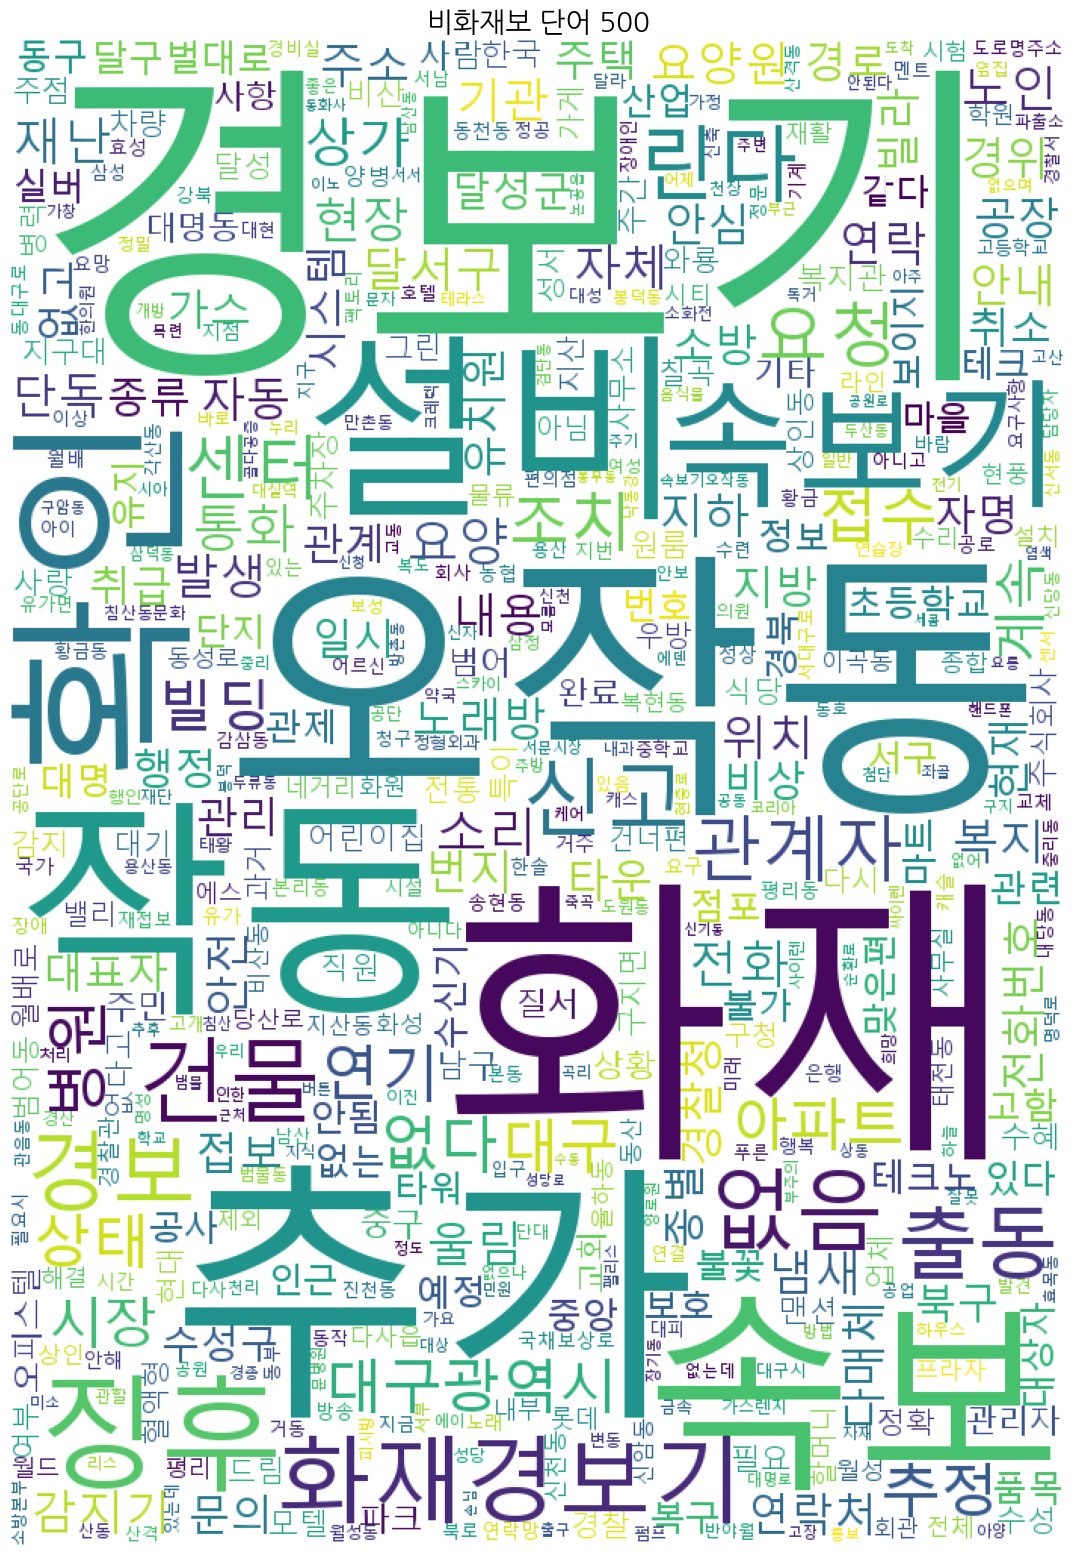

In [81]:
word_freq = []
word_pgr = []
doc_cnt = len(non_fire)
dtm_mat = make_dtm(non_fire, stopwords = [""])
plt.figure( figsize = (20, 20),dpi=100 )
plt.rc('font', family='NanumGothic')
plt.imshow(make_wordcloud(dtm_mat, width = 700, height = 1000))
plt.axis("off")
# plt.savefig(main_path + "/results/{}/{}_wordcloud.png".format(f_name ,year), bbox_inches='tight')
plt.title("비화재보 단어 500",fontsize=20)
plt.show()
plt.close()

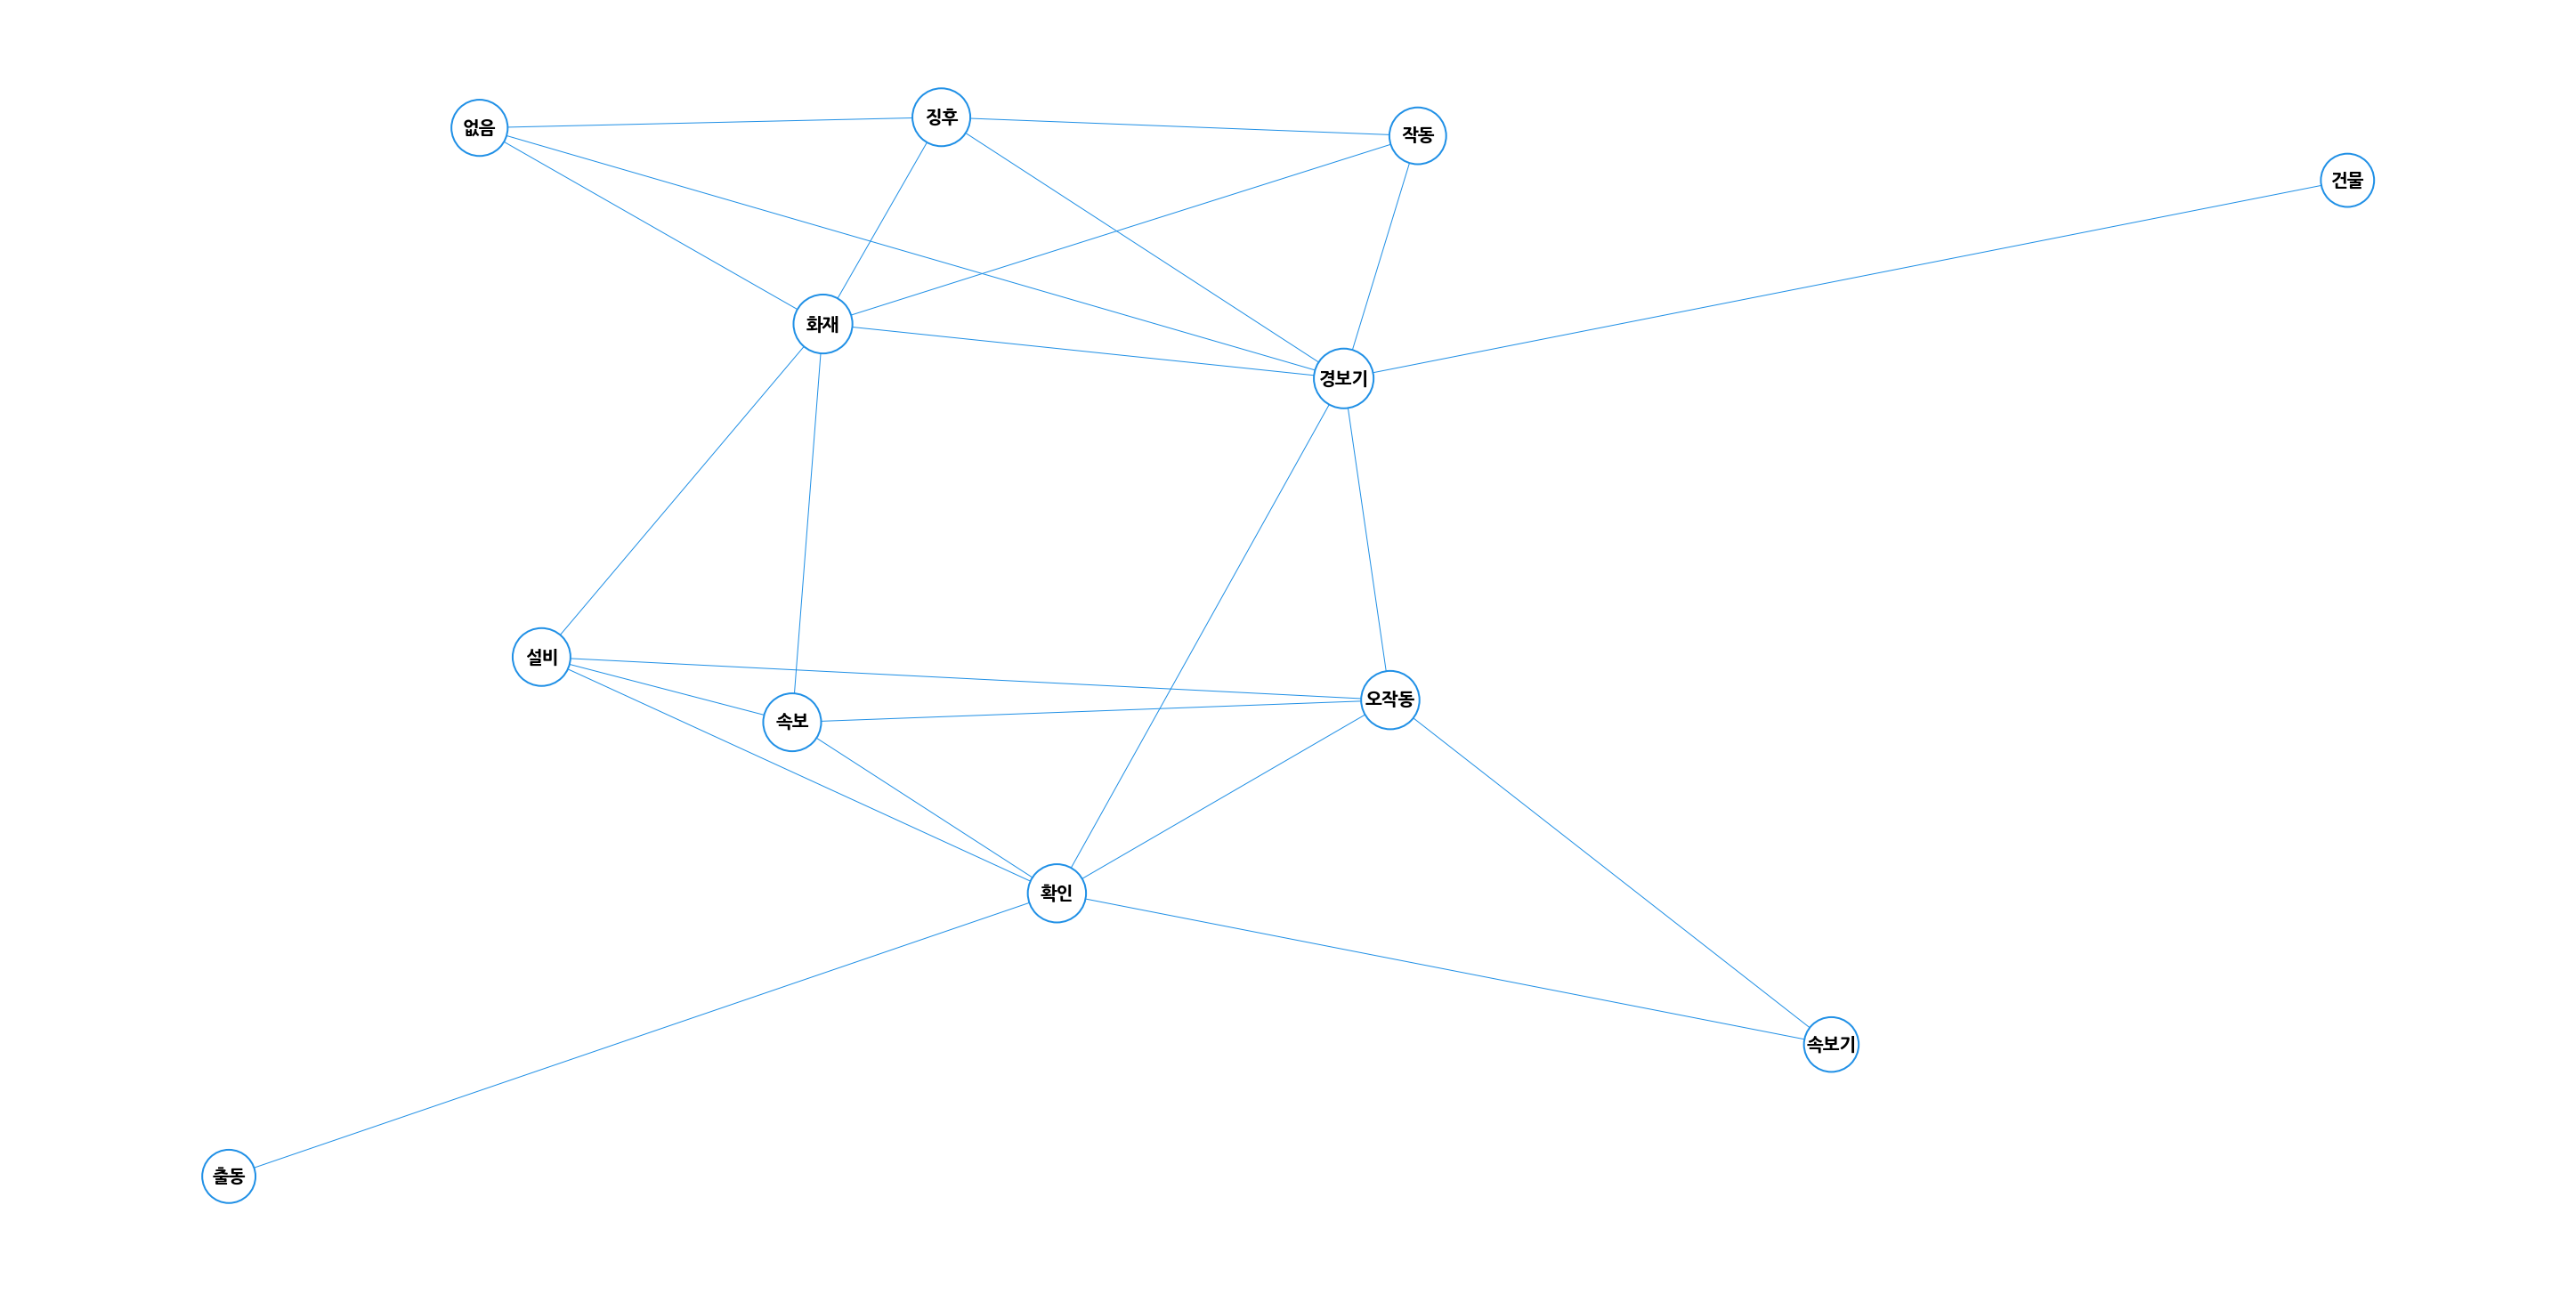

In [95]:
### 단어빈도 및 네트워크 분석 ###
word_freq = []
word_pgr = []

doc_cnt = len(non_fire)
dtm_mat = make_dtm(non_fire, stopwords = ["추가","아아"])
word_divide_doc = pd.DataFrame(pd.Series(dtm_mat.sum(axis = 0), name = "freq"))
word_divide_doc['idf'] = pd.Series(dtm_mat.sum(axis = 0), name = "freq") / doc_cnt
word_freq.append(word_divide_doc)
asso_rules = analy_asso(dtm_mat,support= 0.05, confidence = 0.1)
plt.figure( figsize = (40, 20) )
make_network(asso_rules, font_size = 20,eps = 1, figure = True)
plt.axis("off")
plt.show()
# plt.savefig(main_path + "/results/{}/{}_wordnetwork.png".format(f_name, year), bbox_inches = "tight")
plt.close()

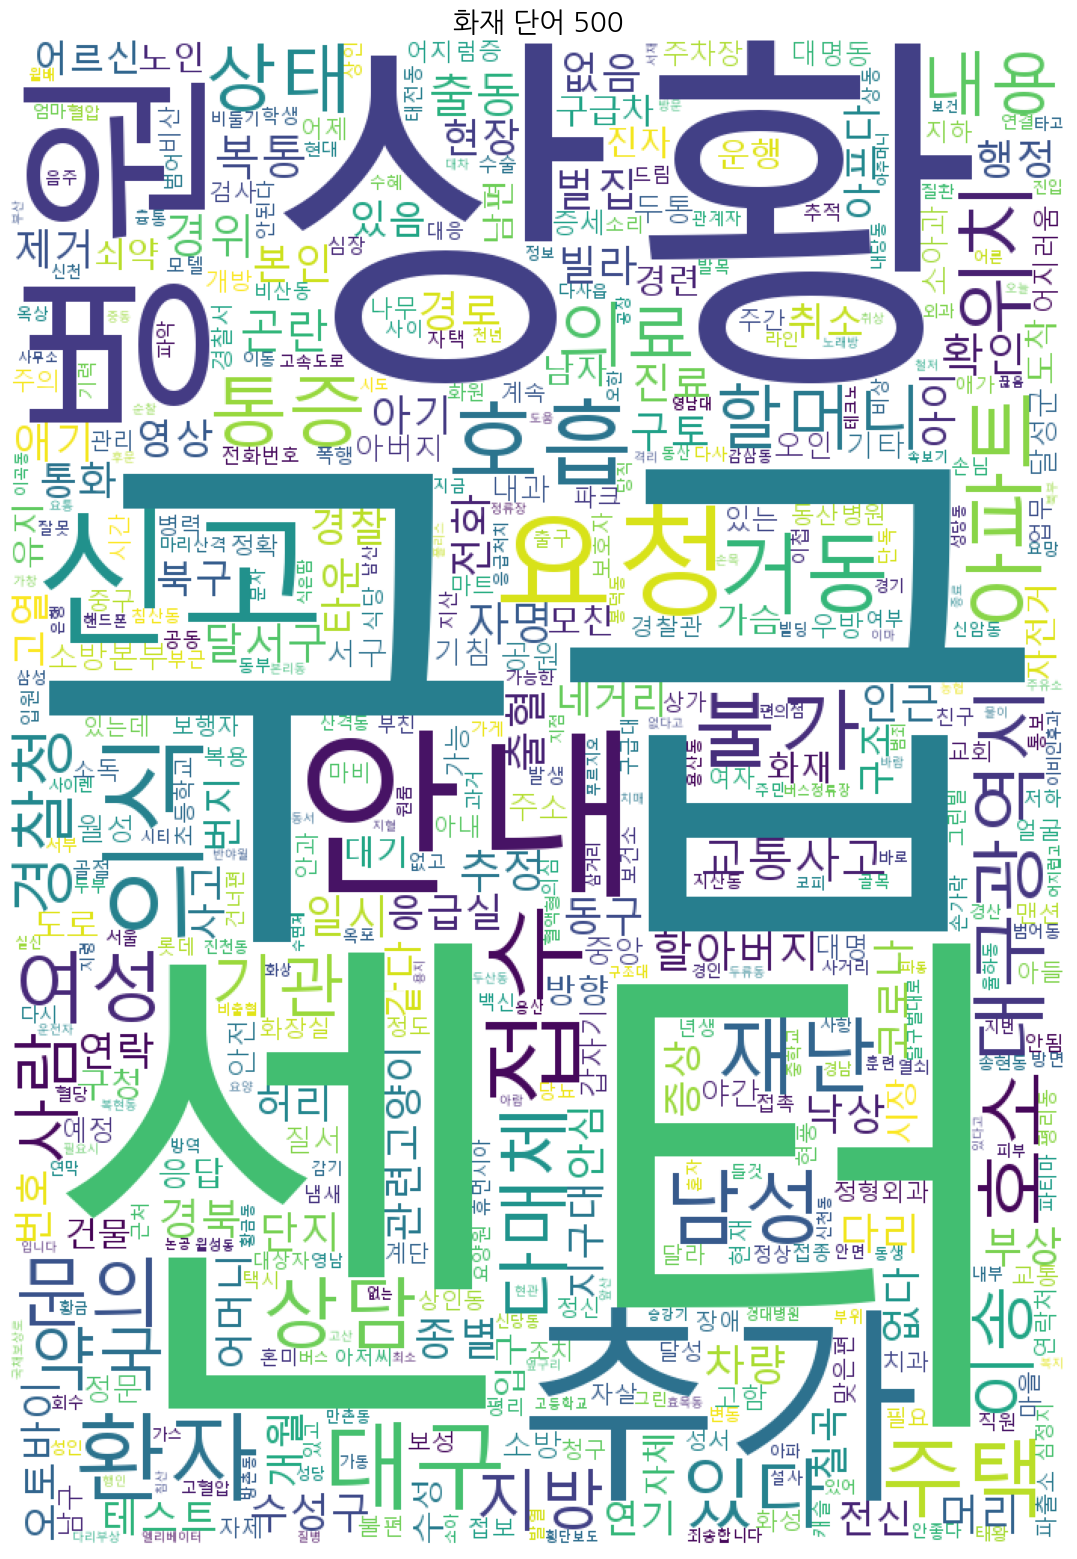

In [82]:
word_freq = []
word_pgr = []
doc_cnt = len(fire)
dtm_mat = make_dtm(fire, stopwords = [''])
plt.figure( figsize = (20, 20),dpi=100 )
plt.rc('font', family='NanumGothic')
plt.imshow(make_wordcloud(dtm_mat, width = 700, height = 1000))
plt.axis("off")
# plt.savefig(main_path + "/results/{}/{}_wordcloud.png".format(f_name ,year), bbox_inches='tight')
plt.title("화재 단어 500",fontsize=20)
plt.show()
plt.close()

In [22]:
### 단어빈도 및 네트워크 분석 ###
word_freq = []
word_pgr = []

doc_cnt = len(fire)
dtm_mat = make_dtm(fire, stopwords = ["추가","아아"])
word_divide_doc = pd.DataFrame(pd.Series(dtm_mat.sum(axis = 0), name = "freq"))
word_divide_doc['idf'] = pd.Series(dtm_mat.sum(axis = 0), name = "freq") / doc_cnt
word_freq.append(word_divide_doc)
asso_rules = analy_asso(dtm_mat,support= 0.05, confidence = 0.1)
plt.figure( figsize = (40, 20) )
make_network(asso_rules, font_size = 20,eps = 1, figure = True)
plt.axis("off")
plt.show()
# plt.savefig(main_path + "/results/{}/{}_wordnetwork.png".format(f_name, year), bbox_inches = "tight")
plt.close()

min_freq:1001 

### Word2vec(CBOW)
CountVectorizer Vectorizing  
TF-IDF Vectorizing



#### 전체데이터

In [89]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

sentences = []
for sen in sents:
    sentences.append(sen.split())

In [90]:
# 파라미터
num_features = 300
min_word_count = 40
num_workers = 4
context = 10
downsampling = 1e-3 # 0.001

In [ ]:
from gensim.models import word2vec
print("Training model ....")
model = word2vec.Word2Vec(sentences, workers=num_workers, size=num_features, min_count=min_word_count, window=context, sample=downsampling)

In [92]:
tmp1 = model.wv.most_similar("속보")
tmp2= model.wv.most_similar("경보")
print(f'속보\n: {tmp1} \n')
print(f'경보\n: {tmp2} \n')

2022-01-24 13:11:21,403 : INFO : precomputing L2-norms of word weight vectors


속보
: [('자동', 0.8564385175704956), ('산업', 0.8405659794807434), ('주식회사', 0.826057493686676), ('한국', 0.8245533108711243), ('요양원', 0.8144120573997498), ('밸리', 0.8116074800491333), ('단대', 0.8028140068054199), ('테크', 0.7947039604187012), ('국가', 0.7946703433990479), ('공사', 0.7895727753639221)] 

경보
: [('방송', 0.8197112083435059), ('계속', 0.7894790172576904), ('소리', 0.7838154435157776), ('다매체', 0.7832159996032715), ('있는데', 0.7672750949859619), ('신고', 0.7647739052772522), ('인근', 0.7597019672393799), ('대피', 0.7518261075019836), ('일반', 0.7481555938720703), ('옆집', 0.7469539642333984)] 



In [93]:
def get_features(words,model, num_features):
    feature_vector = np.zeros((num_features), dtype=np.float32)
    num_words = 0
    index2word_set = set(model.wv.index2word)
    for w in words:
        if w in index2word_set:
            num_words +=1
            feature_vector = np.add(feature_vector, model[w])
    feature_vector = np.divide(feature_vector, num_words)
    return feature_vector

In [94]:
def get_dataset(sentence, model, num_features):
    dataset = list()
    for s in sentence:
        dataset.append(get_features(s, model, num_features))
    FeatureVecs = np.stack(dataset)
    return FeatureVecs

In [95]:
train_data_vecs = get_dataset(sentences, model, num_features)
print(train_data_vecs.shape)

C:\Users\user\AppData\Local\Temp/ipykernel_11532/2435305589.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  feature_vector = np.add(feature_vector, model[w])


(26919, 300)
